# Variables

In [3]:
BATCH_SIZE = 10
NUM_EPOCHS = 50
IMAGE_WIDTH = 650
IMAGE_HEIGHT = 650
LEARNING_RATE=0.01


# Dataset Downloading

Covid-19 Image Classification

In [ ]:
!curl -L -o /content/sample_data/covid19-image-dataset.zip\
  https://www.kaggle.com/api/v1/datasets/download/pranavraikokte/covid19-image-dataset

In [ ]:
from zipfile import ZipFile
with ZipFile('/content/sample_data/covid19-image-dataset.zip') as zp:
  zp.extractall('/content/sample_data/')

# Data Loading

In [ ]:
from torchvision import datasets, transforms

transform = transforms.Compose([transforms.Resize(size=(IMAGE_WIDTH, IMAGE_HEIGHT)), transforms.ToTensor()])
train_ds = datasets.ImageFolder('/content/sample_data/Covid19-dataset/train/', transform)
test_ds = datasets.ImageFolder('/content/sample_data/Covid19-dataset/test/', transform)

In [ ]:
train_ds

We might not have to create a custom dataset, because we can use ImageFolder to create a dataset from an image folder with an organized structure. It will automatically associate the class names to images according to folder names.

https://debuggercafe.com/pytorch-imagefolder-for-training-cnn-models/

In [ ]:
from torch.utils.data import Dataset, DataLoader
import torch


loader = DataLoader(
    dataset=train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2
)

In [ ]:
# train_ds.imgs

Images loaded are of different sizes, which would cause a
```
RuntimeError: stack expects each tensor to be equal size, but got [3, 3480, 4248] at entry 0 and [3, 1303, 1458] at entry 1

```

We can fix that by assuring all images are of the same size. Use a transform for that.

https://discuss.pytorch.org/t/runtimeerror-stack-expects-each-tensor-to-be-equal-size-but-got-3-224-224-at-entry-0-and-3-224-336-at-entry-3/87211

Apparently, we can normalize the channels to make sure brighter colors won't be of more importance. Use a transform for that.

https://stats.stackexchange.com/questions/211436/why-normalize-images-by-subtracting-datasets-image-mean-instead-of-the-current

In [ ]:
import math

iterable_ds = iter(loader)
NUM_IMGS = len(train_ds.imgs)
NUM_BATCHES = math.ceil(NUM_IMGS/BATCH_SIZE)

# Analyzing Data

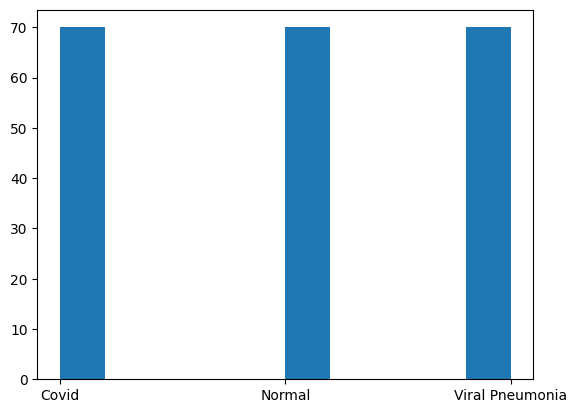

,Img_Uri
Class,
0,70
1,70
2,70


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.DataFrame(train_ds.imgs)
df = df.rename(columns={0: 'Img_Uri', 1: 'Class'})
classes = df.loc[:, 'Class']

plt.hist(classes)
plt.xticks([0, 1, 2], labels=train_ds.classes)
plt.show()

df.groupby(['Class']).count()

In [ ]:
df

,Class,1
0,/content/sample_data/Covid19-dataset/train/Cov...,0
1,/content/sample_data/Covid19-dataset/train/Cov...,0
2,/content/sample_data/Covid19-dataset/train/Cov...,0
3,/content/sample_data/Covid19-dataset/train/Cov...,0
4,/content/sample_data/Covid19-dataset/train/Cov...,0
...,...,...
246,/content/sample_data/Covid19-dataset/train/Vir...,2
247,/content/sample_data/Covid19-dataset/train/Vir...,2
248,/content/sample_data/Covid19-dataset/train/Vir...,2
249,/content/sample_data/Covid19-dataset/train/Vir...,2


# Modifying Data

-> Undersampling

In [ ]:
i = 0
new_imgs = []
for img in train_ds.imgs:
  if img[1] == 0:
    if i >= 70:
      continue
    i += 1

  new_imgs.append(img)

train_ds.imgs = new_imgs

print(len(train_ds.imgs))
print(len(list(filter(lambda x: x[1] == 0, train_ds.imgs))))

210
70


# Making Model

In [ ]:
from torch import nn, softmax, relu

class CNN_Model(nn.Module):
  def __init__(self):
    super().__init__()
    # Defining Layers
    # Input -> CL + RELU -> POOL -> CL + RELU -> POOL -> FLATTEN -> FC -> SOFTMAX (from video)
    # Size: 650x650x3 (width x height x channel)



    self.cl1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, stride=1, padding=1) # out_channels will determine how many filters we wish to apply
     # W = 650, K = 3, S = 1, P = 1 -> size = (650 - 3 + 2 * P)/1 + 1 =  650
     # out: 650 x 650 x 8


    self.p1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
    # W = 650, K = 2, S = 2, P = 0
    # size = (650 - 2 + 2 * 0)/2 + 1 = 648/2 + 1 = 325
    # out : 325 x 325 x 8


    self.cl2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1)
    # out : 325 x 325 x 16

    self.p2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
    # W = 325, K = 2, S = 2, P = 0
    # size = 162.5 ~= 162
    # out : 162 x 162 x 16

    self.flatten = nn.Flatten()

    self.fc1 = nn.Linear(in_features=162*162*16, out_features=3) # 3 classes available

  def forward(self, input):
    output = self.cl1(input)
    output = relu(output)
    output = self.p1(output)

    output = self.cl2(output)
    output = relu(output)
    output = self.p2(output)

    output = self.flatten(output)

    output = self.fc1(output)
    #output = softmax(output) # done by CrossEntropyLoss function

    return output

model = CNN_Model()


# Setting Up Optimizer and Loss Function

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss = nn.CrossEntropyLoss()

# Setting Up Scheduler

In [ ]:
from torch.optim import lr_scheduler

scheduler = lr_scheduler.StepLR(
    optimizer,
    step_size=10,
    gamma=0.5
)

# Training

Apparently, to run on the GPU, we have to send the data itself to the GPU. We can do so with the batches. The loss function also needs the labels to be loaded on the GPU.

https://discuss.pytorch.org/t/how-to-load-all-data-into-gpu-for-training/27609/22?page=2

Also, we need the weights to be on the GPU. We can do that by using the model itself, sending it to the GPU as well.

https://discuss.pytorch.org/t/how-to-load-all-data-into-gpu-for-training/27609/34?page=2

In [ ]:
# GPU or CPU Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(device=device)

Tqdm is a simple library that can be used to generate a loading bar on loops.

https://github.com/tqdm/tqdm

In [ ]:
from tqdm import tqdm
# Loop
for epoch in range(NUM_EPOCHS):
  iterable_ds = iter(loader) # reinitialize batches whenever we run a new epoch
  for i in tqdm(range(NUM_BATCHES), desc=f"Epoch {epoch}"):
    try:
      batch, labels = next(iterable_ds) # we get the images (batch) and corresponding labels. That's returned by __getitem__, it seems.
      batch = batch.to(device=device)
      labels = labels.to(device=device)
      #print(model.cl1.weight.device, batch.device)
      final_outputs = model(batch)

      loss_results = loss(final_outputs, labels)

      optimizer.zero_grad()
      loss_results.backward()
      optimizer.step()

      scheduler.step()
    except StopIteration:
      print(f'Exception Encountered: batch {i}/{NUM_BATCHES} in epoch {epoch}')


Epoch 49: 100%|██████████| 21/21 [00:09<00:00,  2.25it/s]


# Evaluation

Evaluating with Training Data

In [ ]:
import torch
from sklearn.metrics import confusion_matrix
import numpy as np

# Making new Iterable
iterable_ds_2 = iter(loader)

accuracy = 0

with torch.no_grad():
  predicted_classes = np.empty(NUM_IMGS)
  labels_all = np.empty(NUM_IMGS)

  model.cpu()
  for i in tqdm(range(NUM_BATCHES)): # NUM_BATCHES
    batch, labels = next(iterable_ds_2)
    batch = batch.cpu()
    labels = labels.cpu()

    pred = torch.softmax(model(batch), dim=0) # this will run softmax on each score, generating probabilities
    pred_classes = torch.max(pred, dim=1).indices # torch.max with dim=1 will run through every prediction and return the highest probability for that prediction.
    # the .indices will return the indices of thoses highest probabilities, which correspond to the classes.

    right_answers = (pred_classes == labels).sum() # for accuracy calculation
    accuracy += right_answers

    predicted_classes[i*BATCH_SIZE:i*BATCH_SIZE+BATCH_SIZE] = pred_classes[:]
    labels_all[i*BATCH_SIZE:i*BATCH_SIZE+BATCH_SIZE] = labels[:]

  print(f'Accuracy: {accuracy}/{NUM_IMGS} | {(accuracy*100/NUM_IMGS):.4f}%')

  print(confusion_matrix(labels_all, predicted_classes, labels=[0, 1, 2]))


  0%|          | 0/21 [00:00<?, ?it/s]/tmp/ipython-input-1274239813.py:27: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  predicted_classes[i*BATCH_SIZE:i*BATCH_SIZE+BATCH_SIZE] = pred_classes[:]
/tmp/ipython-input-1274239813.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  labels_all[i*BATCH_SIZE:i*BATCH_SIZE+BATCH_SIZE] = labels[:]
100%|██████████| 21/21 [00:25<00:00,  1.20s/it]

Accuracy: 156/210 | 74.2857%
[[66 29  1]
 [ 3 52  2]
 [ 0 19 38]]


In [ ]:
import torch
from sklearn.metrics import confusion_matrix
import numpy as np

# Making new Iterable
test_loader = DataLoader(
    dataset=test_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2
)

NUM_TEST_IMGS = len(test_ds.imgs)
NUM_TEST_BATCHES = math.ceil(NUM_TEST_IMGS/BATCH_SIZE)
iterable_ds_2 = iter(test_loader)

accuracy = 0

with torch.no_grad():
  predicted_classes = np.empty(NUM_TEST_IMGS)
  labels_all = np.empty(NUM_TEST_IMGS)
  model.cpu()
  for i in tqdm(range(NUM_TEST_BATCHES)): # NUM_BATCHES
    batch, labels = next(iterable_ds_2)
    batch = batch.cpu()
    labels = labels.cpu()
    pred = torch.softmax(model(batch), dim=0) # this will run softmax on each score, generating probabilities
    pred_classes = torch.max(pred, dim=1).indices # torch.max with dim=1 will run through every prediction and return the highest probability for that prediction.
    # the .indices will return the indices of thoses highest probabilities, which correspond to the classes.

    right_answers = (pred_classes == labels).sum() # for accuracy calculation
    accuracy += right_answers

    predicted_classes[i*BATCH_SIZE:i*BATCH_SIZE+BATCH_SIZE] = pred_classes[:]
    labels_all[i*BATCH_SIZE:i*BATCH_SIZE+BATCH_SIZE] = labels[:]

  print(f'Accuracy: {accuracy}/{NUM_TEST_IMGS} | {(accuracy*100/NUM_TEST_IMGS):.4f}%')

  print(confusion_matrix(labels_all, predicted_classes, labels=[0, 1, 2]))


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipython-input-3948820383.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  predicted_classes[i*BATCH_SIZE:i*BATCH_SIZE+BATCH_SIZE] = pred_classes[:]
/tmp/ipython-input-3948820383.py:35: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  labels_all[i*BATCH_SIZE:i*BATCH_SIZE+BATCH_SIZE] = labels[:]
100%|██████████| 7/7 [00:06<00:00,  1.16it/s]

Accuracy: 43/66 | 65.1515%
[[18  8  0]
 [ 0 16  4]
 [ 1 10  9]]
